In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import fashion_mnist, mnist
import numpy as np
import shap
import json
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Ładowanie datasetu

In [2]:
dataset = mnist.load_data()

In [3]:
train_data, test_data = dataset
X_train, y_train = train_data
X_test, y_test = test_data

X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float32)

X_train.shape

(60000, 28, 28, 1)

In [4]:
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

class_names = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9,
}

## Konfiguracja modelu sieci

In [5]:
input_shape = X_train[0].shape
num_classes = 10

# input_ = layers.Input(shape=input_shape)
# x = layers.Flatten()(input_)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dense(64, activation='relu')(x)
# output = layers.Dense(10, activation='softmax')(x)
# model = keras.Model(inputs=input_, outputs=output)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

## Trenowanie modelu

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_test, y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 62s 1ms/sample - loss: 2.1731 - accuracy: 0.8043 - val_loss: 0.1134 - val_accuracy: 0.9643
Epoch 2/5
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.2114 - accuracy: 0.9363 - val_loss: 0.0744 - val_accuracy: 0.9770
Epoch 3/5
60000/60000 [==============================] - 56s 925us/sample - loss: 0.1575 - accuracy: 0.9513 - val_loss: 0.0652 - val_accuracy: 0.9786
Epoch 4/5
60000/60000 [==============================] - 59s 987us/sample - loss: 0.1274 - accuracy: 0.9602 - val_loss: 0.0514 - val_accuracy: 0.9831
Epoch 5/5
60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1116 - accuracy: 0.9666 - val_loss: 0.0481 - val_accuracy: 0.9838


In [13]:
model.save_weights('mnist_weights.h5')

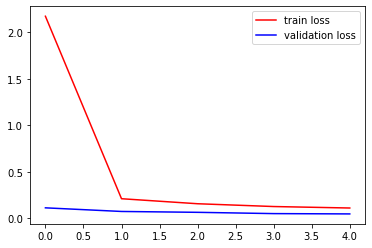

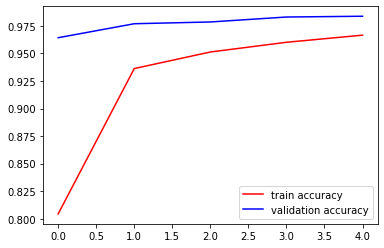

In [19]:
x = np.arange(5)
plt.plot(x, history.history['loss'], color='red', label='train loss')
plt.plot(x, history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.show()

plt.plot(x, history.history['accuracy'], color='red', label='train accuracy')
plt.plot(x, history.history['val_accuracy'], color='blue', label='validation accuracy')
plt.legend()
plt.show()

## Ładowanie wag modelu

In [6]:
model.load_weights('mnist_weights.h5')

## Selekcja przykładowych próbek

In [7]:
SAMPLES_CLASS = 9
TEST_SAMPLES_COUNT = 8

class_indices = np.argwhere(y_test == SAMPLES_CLASS).flatten()
indices_to_explain = np.random.choice(class_indices, TEST_SAMPLES_COUNT, replace=False)
images_to_explain = X_test[indices_to_explain]

## Wyjaśnienie próbek za pomocą DeepExplainer'a

In [8]:
%%time
# background = np.zeros((1, 28, 28, 1))
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(images_to_explain)
np_shap = np.array(shap_values)

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


## Znalezienie najciekawszych próbek

Spośród wybranych losowo próbek znajdujemy te, których klasyfikacja była trudna dla modelu oraz te, które posiadają bardzo wysokie i/lub niskie wartości Shapley'a.

In [9]:
model.predict(images_to_explain).round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.99],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],
      dtype=float32)

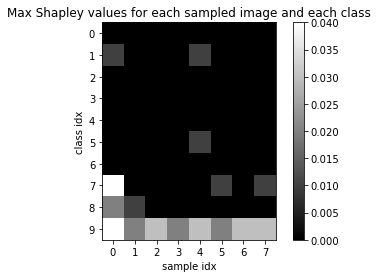

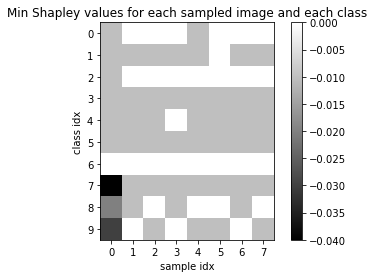

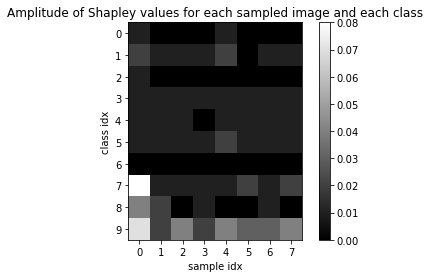

In [10]:
maxes = np_shap.reshape((*np_shap.shape[:2], -1)).max(axis=-1).round(2)
mins = np_shap.reshape((*np_shap.shape[:2], -1)).min(axis=-1).round(2)
amplitude = maxes - mins

def plot_stuff(array, title):
    plt.imshow(array, cmap='gray')
    plt.colorbar()
    plt.xticks(range(TEST_SAMPLES_COUNT))
    plt.xlabel('sample idx')
    plt.yticks(range(len(class_names)))
    plt.ylabel('class idx')
    plt.title(title)
    plt.show()

plot_stuff(maxes, 'Max Shapley values for each sampled image and each class')
plot_stuff(mins, 'Min Shapley values for each sampled image and each class')
plot_stuff(amplitude, 'Amplitude of Shapley values for each sampled image and each class')

## Demonstracja znalezionych wartości Shapley'a dla wybranych próbek

In [51]:
def plot_shap_values(shap_values, classes_indices_to_explain, samples_to_plot, images, class_names):
    np_shap = np.array(shap_values)
    labels = np.array([[f'Explained class {class_names[idx]}' for idx in classes_indices_to_explain]])
    for sample_idx in samples_to_plot:
        print(f'Explained Shapley values for sample {sample_idx}')
        shap_plot_input = list(np_shap[classes_indices_to_explain][:, [sample_idx]])
        shap.image_plot(shap_plot_input, images[[sample_idx]], labels)

Explained Shapley values for sample 0


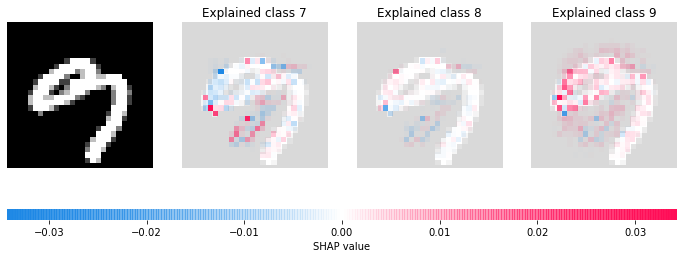

In [12]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=[0], 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 7


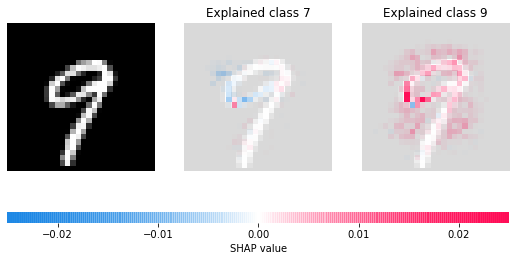

In [13]:
plot_shap_values(shap_values=shap_values,
                 classes_indices_to_explain=[7, 9], 
                 samples_to_plot=[7], 
                 images=images_to_explain,
                 class_names=class_names)

## Aplikacja rozmycia gaussowskiego na znalezionych wartościach Shapley'a

W celu nieco bardziej intuicyjnej prezentacji działania Shap values aplikujemy na znalezione wartości rozmycie gaussowskie pozwalające łatwiej zauważyć, które części obrazu wpływają na predykcję

In [14]:
def blur_shap_values(shap_values, gaussian_blur_sigma):
    classes_count = len(shap_values)
    samples_count = shap_values[0].shape[0]
    
    blurred_shap_values = []
    for class_idx in range(classes_count):
        blurred = []
        for sample_idx in range(samples_count):
            blurred.append(gaussian_filter(shap_values[class_idx][sample_idx], sigma=gaussian_blur_sigma))
        blurred_shap_values.append(blurred)
    return blurred_shap_values

In [18]:
blurred_shap_values = blur_shap_values(shap_values, 1)

Explained Shapley values for sample 7


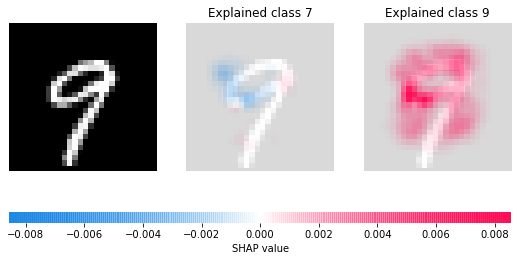

In [19]:
plot_shap_values(shap_values=blurred_shap_values,
                 classes_indices_to_explain=[7, 9], 
                 samples_to_plot=[7], 
                 images=images_to_explain,blur_shap_values
                 class_names=class_names)

## Analiza próbek błędnie sklasyfikowanych

Przeanalizuj błędnie sklasyfikowane próbki za pomocą DeepExplainera analogicznie do pokazanych wyżej przykładów.

In [39]:
pred = np.argmax(model.predict(X_test), axis=-1)
pred

array([7, 2, 1, ..., 4, 5, 6])

In [40]:
np.mean(pred == y_test)

0.9838

In [41]:
incorrect_indices = pred != y_test
samples = X_test[incorrect_indices]
true_labels = y_test[incorrect_indices]
pred_labels = pred[incorrect_indices]

In [42]:
X_train.shape

(60000, 28, 28, 1)

In [43]:
np.mean(X_train, axis=0)[np.newaxis, :].shape

(1, 28, 28, 1)

In [49]:
%%time

SAMPLES_TO_VISUALIZE = 15

samples = samples[:SAMPLES_TO_VISUALIZE]
true_labels = true_labels[:SAMPLES_TO_VISUALIZE]
pred_labels = pred_labels[:SAMPLES_TO_VISUALIZE]

background = np.zeros((1, 28, 28, 1))
# background = np.mean(X_train, axis=0)[np.newaxis, :]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(samples)

CPU times: user 11.6 s, sys: 13.2 s, total: 24.9 s
Wall time: 8.66 s


Explained Shapley values for sample 0


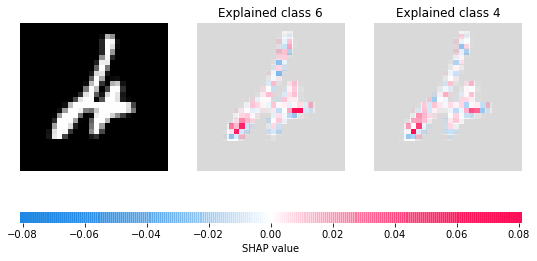

Explained Shapley values for sample 1


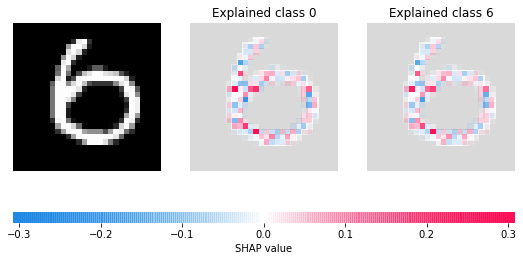

Explained Shapley values for sample 2


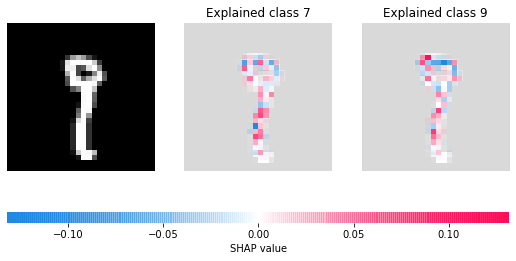

Explained Shapley values for sample 3


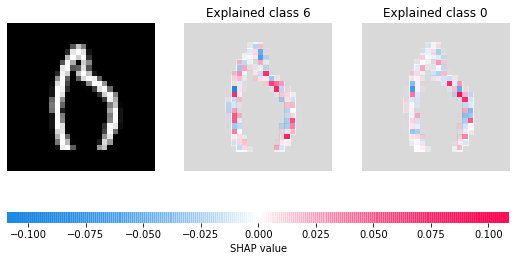

Explained Shapley values for sample 4


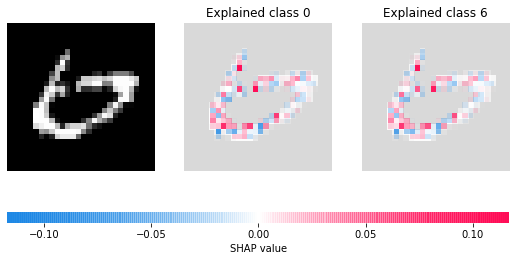

Explained Shapley values for sample 5


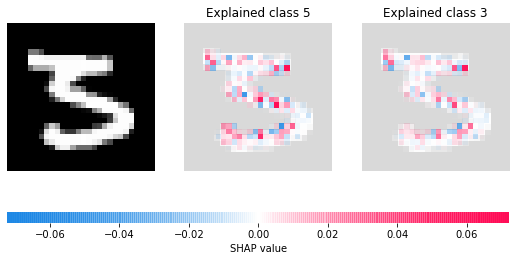

Explained Shapley values for sample 6


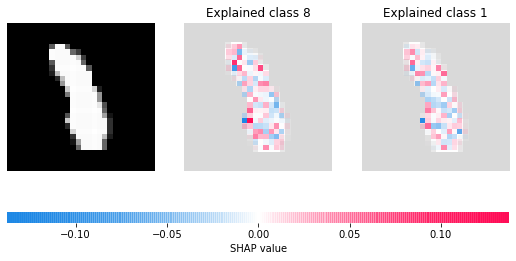

Explained Shapley values for sample 7


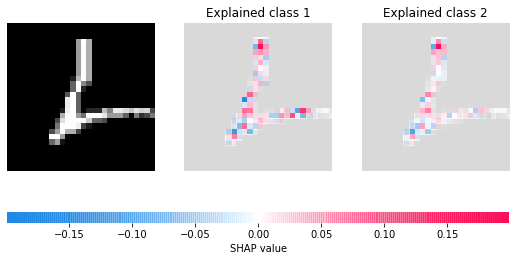

Explained Shapley values for sample 8


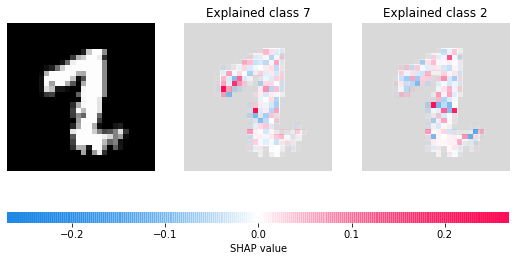

Explained Shapley values for sample 9


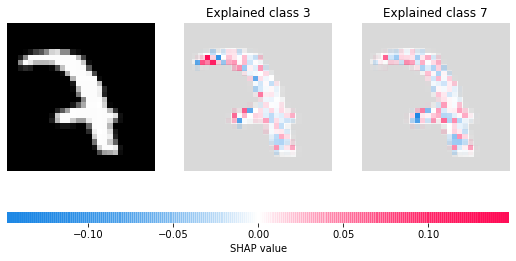

Explained Shapley values for sample 10


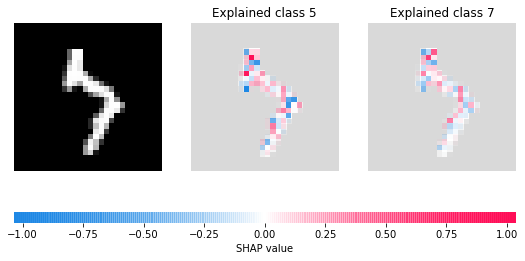

Explained Shapley values for sample 11


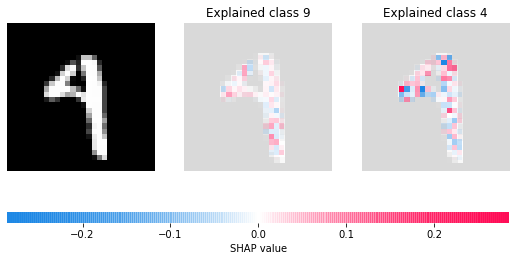

Explained Shapley values for sample 12


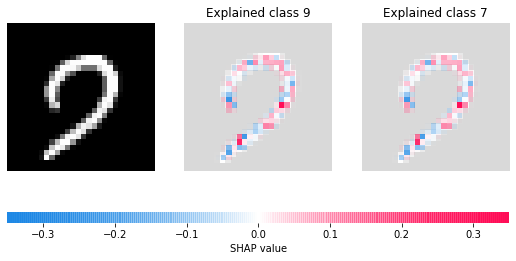

Explained Shapley values for sample 13


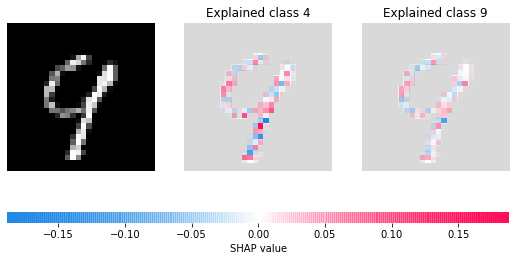

Explained Shapley values for sample 14


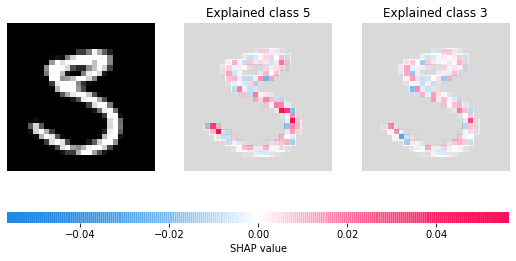

In [52]:
for i in range(SAMPLES_TO_VISUALIZE):
    plot_shap_values(shap_values=shap_values,
                     classes_indices_to_explain=[pred_labels[i], true_labels[i]], 
                     samples_to_plot=[i], 
                     images=samples,
                     class_names=class_names)

Explained Shapley values for sample 0


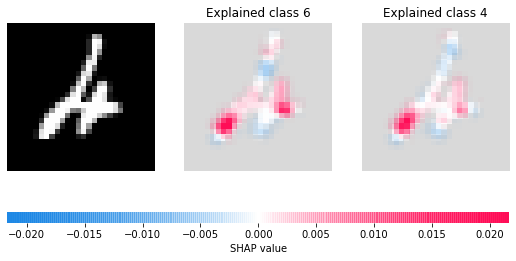

Explained Shapley values for sample 1


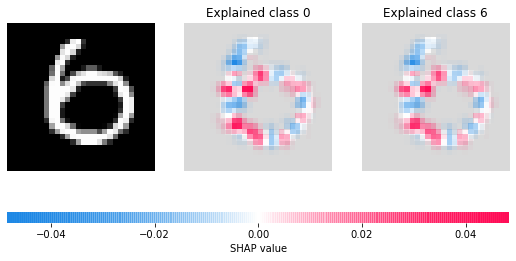

Explained Shapley values for sample 2


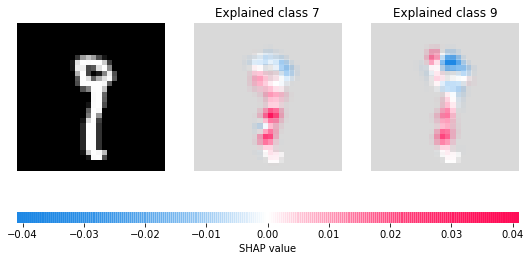

Explained Shapley values for sample 3


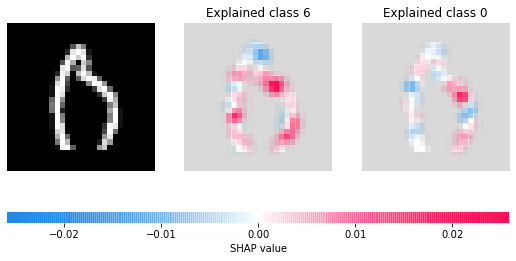

Explained Shapley values for sample 4


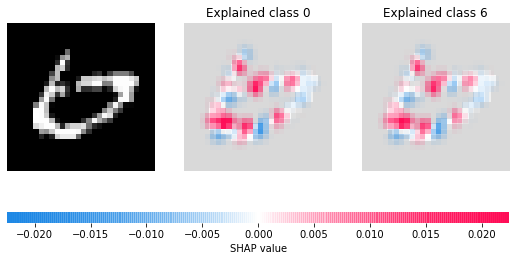

Explained Shapley values for sample 5


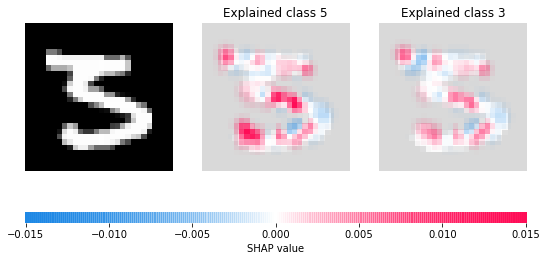

Explained Shapley values for sample 6


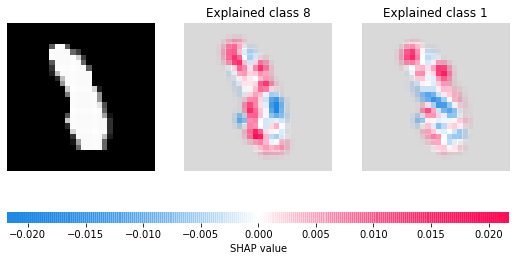

Explained Shapley values for sample 7


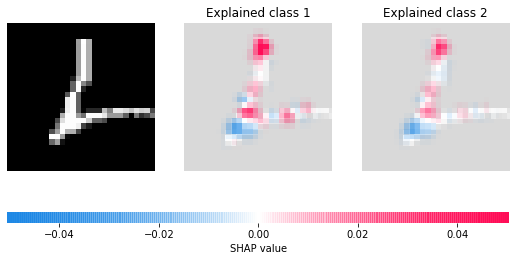

Explained Shapley values for sample 8


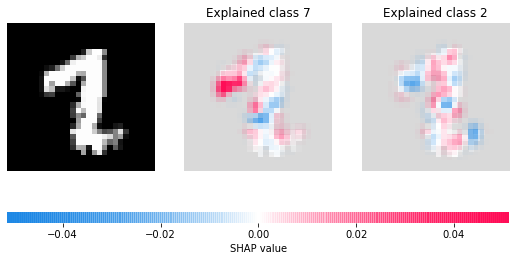

Explained Shapley values for sample 9


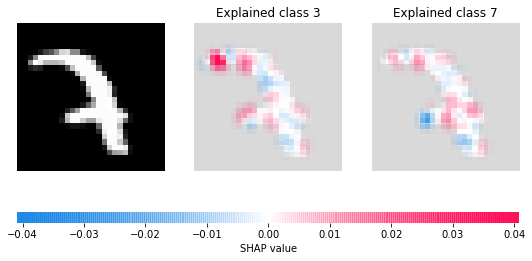

Explained Shapley values for sample 10


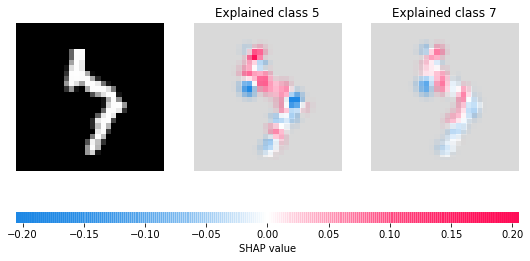

Explained Shapley values for sample 11


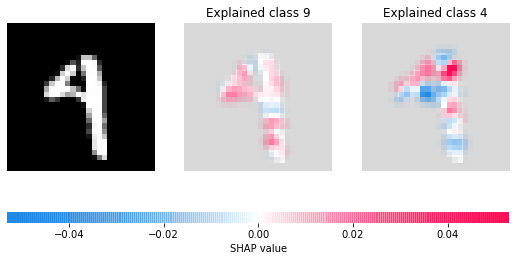

Explained Shapley values for sample 12


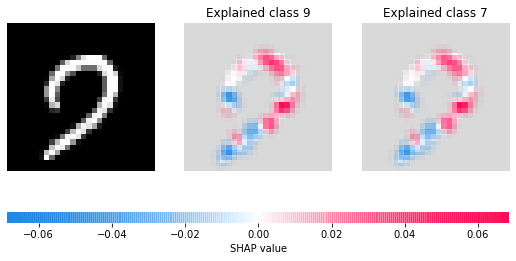

Explained Shapley values for sample 13


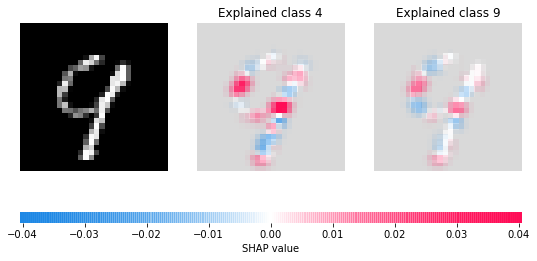

Explained Shapley values for sample 14


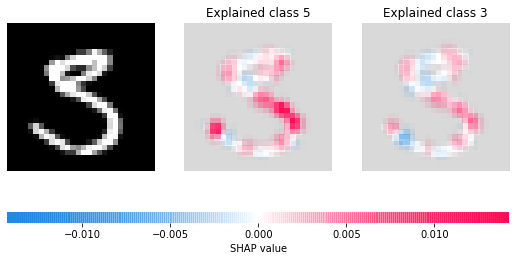

In [53]:
blurred_shap_values = blur_shap_values(shap_values, 1)
for i in range(SAMPLES_TO_VISUALIZE):
    plot_shap_values(shap_values=blurred_shap_values,
                     classes_indices_to_explain=[pred_labels[i], true_labels[i]], 
                     samples_to_plot=[i], 
                     images=samples,
                     class_names=class_names)

## KernelExplainer

In [67]:
def predict_wrapper(model):
    def wrapped(flat_input):
        return model.predict(flat_input.reshape(-1, 28, 28, 1))
    
    return wrapped

In [89]:
np.mean(X_train, axis=0).reshape(1, -1).shape

(1, 784)

In [96]:
%%time
background = np.zeros((1, 28, 28, 1)).reshape(1, -1)
explainer = shap.KernelExplainer(predict_wrapper(model), background)
shap_values = explainer.shap_values(images_to_explain.reshape(-1, 28 * 28))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


CPU times: user 54.6 s, sys: 1min 1s, total: 1min 56s
Wall time: 30.2 s


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [99]:
shhh = np.array(shap_values).reshape((10, TEST_SAMPLES_COUNT, 28, 28, 1))

Explained Shapley values for sample 0


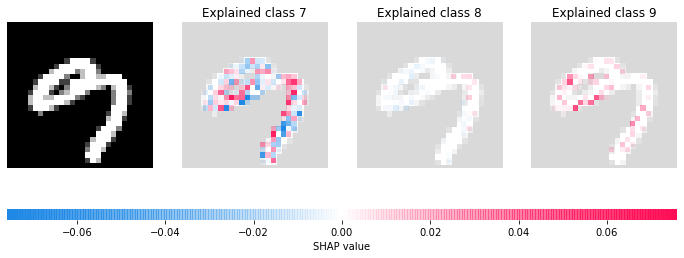

Explained Shapley values for sample 1


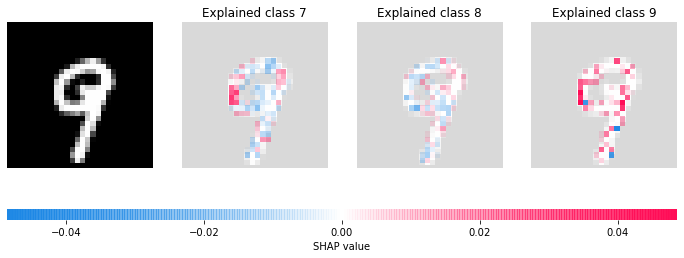

Explained Shapley values for sample 2


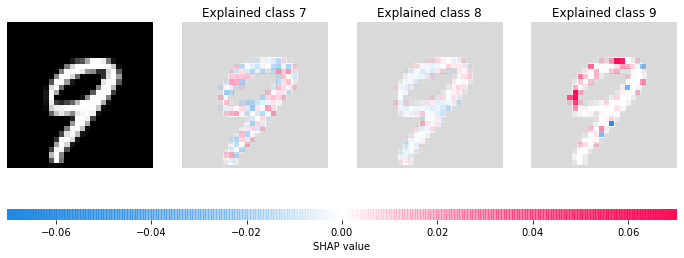

Explained Shapley values for sample 3


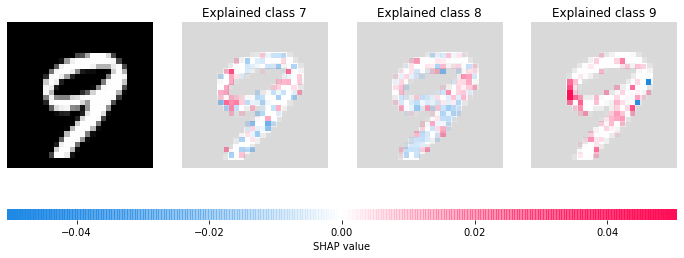

Explained Shapley values for sample 4


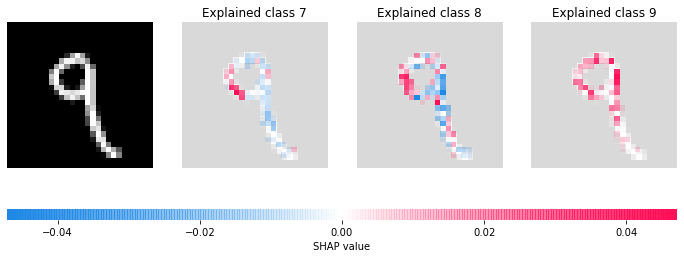

Explained Shapley values for sample 5


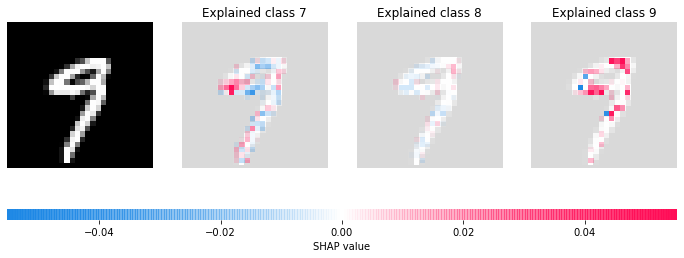

Explained Shapley values for sample 6


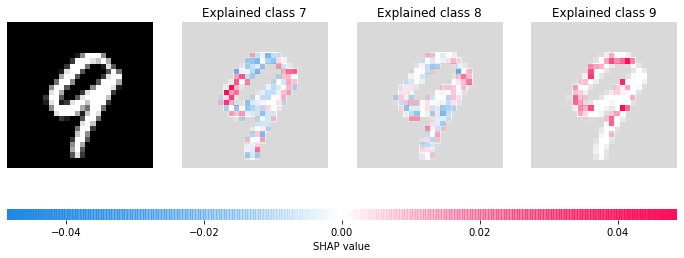

Explained Shapley values for sample 7


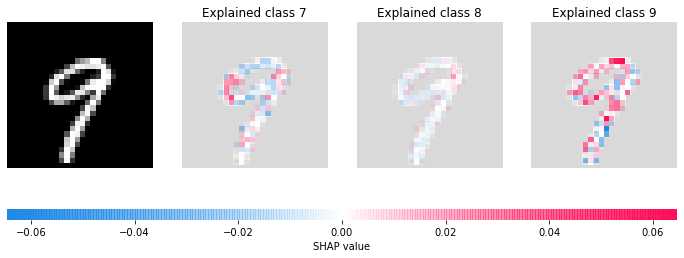

In [100]:
plot_shap_values(shap_values=list(shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)

Explained Shapley values for sample 0


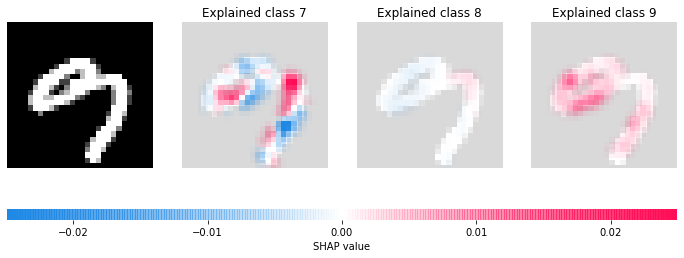

Explained Shapley values for sample 1


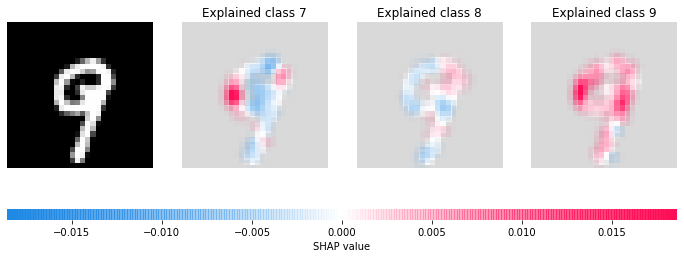

Explained Shapley values for sample 2


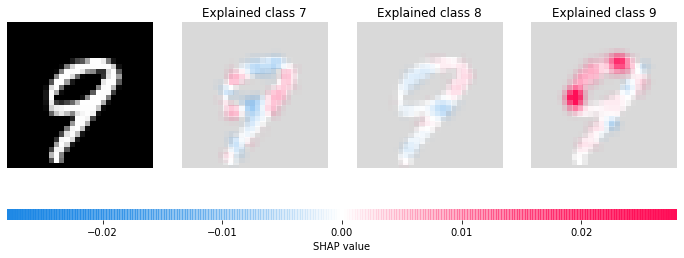

Explained Shapley values for sample 3


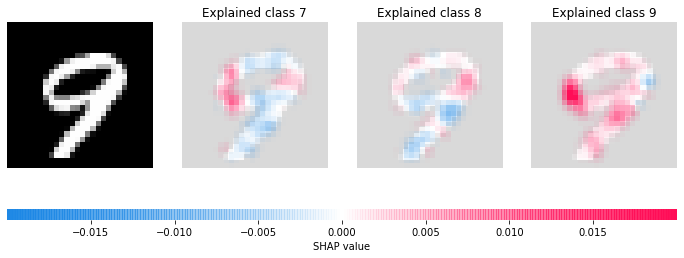

Explained Shapley values for sample 4


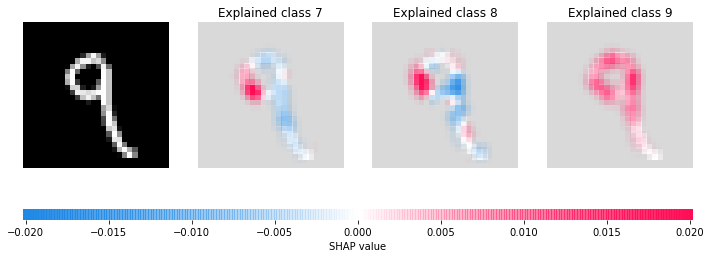

Explained Shapley values for sample 5


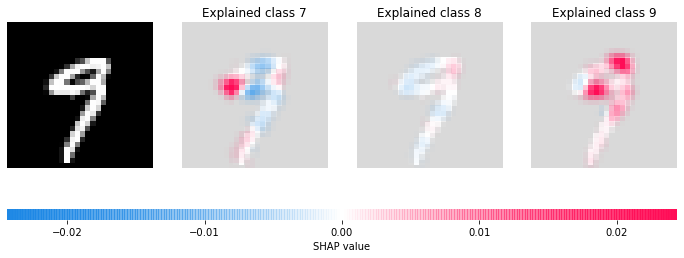

Explained Shapley values for sample 6


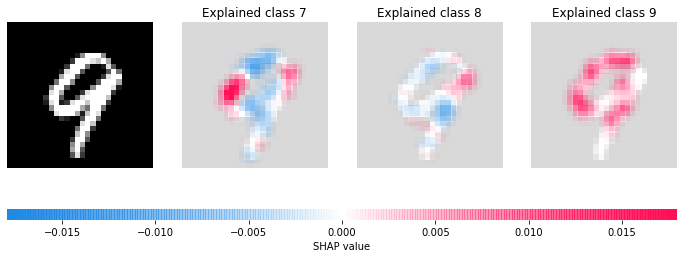

Explained Shapley values for sample 7


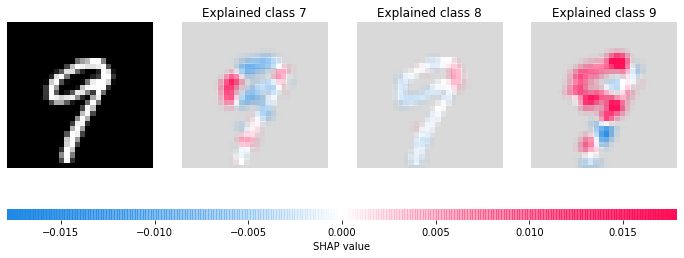

In [101]:
blurred_shhh = blur_shap_values(shhh, 1)
plot_shap_values(shap_values=list(blurred_shhh),
                 classes_indices_to_explain=[7, 8, 9], 
                 samples_to_plot=range(8), 
                 images=images_to_explain,
                 class_names=class_names)